## Restaurants in Hyderabad

### Importing Libraries

In [1]:
# importing Libraries
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot')

import lxml
# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library


### Scraping table containg neighborhoods of Hyderabad

In [2]:
# Scraping table from Wikipedia
df=pd.read_html('https://www.mapsofindia.com/pincode/india/telangana/hyderabad/', header=0)
df=df[0]

# Changing column names
df.columns=df.iloc[0]
df.drop(0,inplace=True)

# Dropping columns that will not be used
df.drop(['State','District'],axis=1,inplace=True)

df

,Location,Pincode
1,A.G.college,500030
2,A.Gs office,500004
3,A.Gs. staff quarters,500045
4,Administrative Buildings,500007
5,Afzalgunj,500012
...,...,...
224,Yadgarpalli,501301
225,Yakutpura,500023
226,Yousufguda,500045
227,Zamistanpur,500020


In [3]:
df.describe()

,Location,Pincode
count,228,228
unique,228,67
top,Padmavathi Nagar,500015
freq,1,20


On observation there are 67 unique Pincodes

In [4]:
# Grouping by Pincode
df = df.groupby('Pincode')['Location'].agg(['unique'])
df=df.reset_index()
df['unique']=df['unique'].apply(', '.join)
df=df.rename(columns={'unique':'Location'})
df

,Pincode,Location
0,500001,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz..."
1,500002,"Hyderabad Jubilee, Moghalpura, Tagarikanaka"
2,500003,"Begumpet Policelines, Kingsway, Mg Road, Picke..."
3,500004,"A.Gs office, Anandnagar, Bazarghat, Khairataba..."
4,500005,"Balapur, Crp Camp, Keshogiri, Mamidipalli, Pah..."
...,...,...
62,500085,Jntu Kukat pally
63,500095,"Putlibowli, Ramkoti, State Bank of india"
64,501101,Vikarabad
65,501201,Anantagiri


### Using Geopy Library to get latitudes and longitudes

In [5]:
address = 'Hyderabad, India'

geolocator = Nominatim(user_agent="Hyderabad")
location = geolocator.geocode(address)
latitude_Hyderabad = location.latitude
longitude_Hyderabad = location.longitude
print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude_Hyderabad, longitude_Hyderabad))

The geograpical coordinate of Hyderabad are 17.360589, 78.4740613.


In [6]:
def get_lat_long(Pincode):
    try:
        address = '{}, Hyderabad, India'.format(Pincode)
        geolocator = Nominatim(user_agent="Hyderabad")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {} are {}, {}.'.format(Pincode, latitude, longitude))
        return pd.Series([latitude,longitude])
    except:
        return pd.Series([np.nan,np.nan])

In [7]:
df[['Latitude','Longitude']]=df['Pincode'].apply(get_lat_long)
df

The geograpical coordinate of 500001 are 17.398710263173296, 78.47214705820414.
The geograpical coordinate of 500002 are 17.380252038232054, 78.46678322013956.
The geograpical coordinate of 500003 are 17.441898303856604, 78.49083968875789.
The geograpical coordinate of 500004 are 17.401951440775097, 78.46326370373014.
The geograpical coordinate of 500005 are 17.316797439208486, 78.48432632956319.
The geograpical coordinate of 500006 are 17.3521271, 78.4532015.
The geograpical coordinate of 500007 are 17.41814574187567, 78.52810183695023.
The geograpical coordinate of 500008 are 17.4042043, 78.3305483.
The geograpical coordinate of 500012 are 17.37678253988475, 78.47042310080363.
The geograpical coordinate of 500013 are 17.39474591541543, 78.52926554053593.
The geograpical coordinate of 500015 are 17.475171598252942, 78.49420286416814.
The geograpical coordinate of 500016 are 17.437497233239373, 78.4567557812146.
The geograpical coordinate of 500017 are 17.43133141169718, 78.53318290901

,Pincode,Location,Latitude,Longitude
0,500001,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147
1,500002,"Hyderabad Jubilee, Moghalpura, Tagarikanaka",17.380252,78.466783
2,500003,"Begumpet Policelines, Kingsway, Mg Road, Picke...",17.441898,78.490840
3,500004,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",17.401951,78.463264
4,500005,"Balapur, Crp Camp, Keshogiri, Mamidipalli, Pah...",17.316797,78.484326
...,...,...,...,...
62,500085,Jntu Kukat pally,17.497373,78.389747
63,500095,"Putlibowli, Ramkoti, State Bank of india",17.384924,78.486426
64,501101,Vikarabad,17.528026,78.267025
65,501201,Anantagiri,NaN,NaN


### Removing NAN values

In [8]:
df.isnull().sum()

Pincode      0
Location     0
Latitude     2
Longitude    2
dtype: int64

In [9]:
df1 = df[df.isna().any(axis=1)]
df1

,Pincode,Location,Latitude,Longitude
15,500022,Central Secretariat,NaN,NaN
65,501201,Anantagiri,NaN,NaN


In [10]:
address = 'Central Secretariat, Hyderabad, India'

geolocator = Nominatim(user_agent="Hyderabad")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude_Hyderabad, longitude_Hyderabad))
df.loc[df.Location == 'Central Secretariat','Latitude']=df.loc[df.Location == 'Central Secretariat','Latitude'].replace(np.nan,latitude)
df.loc[df.Location == 'Central Secretariat','Longitude']=df.loc[df.Location == 'Central Secretariat','Longitude'].replace(np.nan,longitude)

The geograpical coordinate of Hyderabad are 17.360589, 78.4740613.


In [11]:
address = 'Anantagiri, Hyderabad, India'
try:
    geolocator = Nominatim(user_agent="Hyderabad")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude_Hyderabad, longitude_Hyderabad))
except:
    print('Coordinates not found')

Coordinates not found


In [12]:
address = '501201, Hyderabad, India'
try:
    geolocator = Nominatim(user_agent="Hyderabad")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude_Hyderabad, longitude_Hyderabad))
except:
    print('Coordinates not found')

Coordinates not found


Coordinates of Anantagiri cannot be found, therefore hardcoding through google search<br>
Latitude=17.3608, Longitude=78.4292

In [13]:
df.loc[df.Location == 'Anantagiri','Latitude']=df.loc[df.Location == 'Anantagiri','Latitude'].replace(np.nan,17.3608)
df.loc[df.Location == 'Anantagiri','Longitude']=df.loc[df.Location == 'Anantagiri','Longitude'].replace(np.nan,78.4292)

In [14]:
df.isnull().sum()

Pincode      0
Location     0
Latitude     0
Longitude    0
dtype: int64

### Cleaned Data

In [15]:
df

,Pincode,Location,Latitude,Longitude
0,500001,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147
1,500002,"Hyderabad Jubilee, Moghalpura, Tagarikanaka",17.380252,78.466783
2,500003,"Begumpet Policelines, Kingsway, Mg Road, Picke...",17.441898,78.490840
3,500004,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",17.401951,78.463264
4,500005,"Balapur, Crp Camp, Keshogiri, Mamidipalli, Pah...",17.316797,78.484326
...,...,...,...,...
62,500085,Jntu Kukat pally,17.497373,78.389747
63,500095,"Putlibowli, Ramkoti, State Bank of india",17.384924,78.486426
64,501101,Vikarabad,17.528026,78.267025
65,501201,Anantagiri,17.360800,78.429200


### Visualizing using folium

In [16]:
map_h = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, pin, Neighborhood in zip(df['Latitude'], df['Longitude'], df['Pincode'], df['Location']):
    label = '{}, {}'.format(Neighborhood, pin)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_h)  
    
map_h

### Using FourSquare API to explore the neighborhood

In [17]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

In [18]:
# defining radius and limit of venues to get
radius=500
LIMIT=200

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
hyderabad_venues = getNearbyVenues(names=df['Location'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazzampura, Seetharampet, State Bank of hyderabad
Hyderabad Jubilee, Moghalpura, Tagarikanaka
Begumpet Policelines, Kingsway, Mg Road, Picket, Secunderabad
A.Gs office, Anandnagar, Bazarghat, Khairatabad, Padmavathi Nagar, Parishram Bhawan, Shyam Nagar, Vidhan Sabha
Balapur, Crp Camp, Keshogiri, Mamidipalli, Pahadishareef
Dhoolpet, Karwan Sahu, Mangalhat
Administrative Buildings, Iict, Jama I osmania, Ngri, Tarnaka
Dargah Hussain shahwali, Golconda, Hyder Shah kote, Kakatiya Nagar, Lunger House, Nanakramguda, Sakkubai Nagar, Toli Chowki
Afzalgunj, Begumbazar, Osmania General hospital
Amberpet, Central Police lines, Hyderabad Public school, Seminary, Srinivasapuram, Zindatelismath
Aliabad, Anantaram, Atvelli, Dabirpur, Gajularamaram, Girmapur, Gowdavalli, Jaggamguda, Jeedimetla, Kolthur, Kushaiguda, Kutbullapur, Lalgadi Malakpet, Mudchintanapalli, Nutankal, Pedalaxmapur, Pragatinagar, Ravalkol, Suraram, Thumkunta
Begumpet, Hyd Airport ii, Hyd Ai

In [21]:
hyderabad_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147,Lal Bahadur Shastri Stadium,17.399140,78.472666,Stadium
1,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147,Blue Diamond,17.399272,78.474750,Chinese Restaurant
2,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147,Hotel Megacity,17.401133,78.475990,Hotel Bar
3,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147,Westside,17.398573,78.471985,Clothing Store
4,"Hyderabad Jubilee, Moghalpura, Tagarikanaka",17.380252,78.466783,Laxman Ki Bandi,17.378895,78.463973,South Indian Restaurant
...,...,...,...,...,...,...,...
450,Vikarabad,17.528026,78.267025,Axis Bank ATM,17.528612,78.271391,ATM
451,Anantagiri,17.360800,78.429200,HDFC Bank ATM,17.359728,78.428689,ATM
452,Anantagiri,17.360800,78.429200,mithas vatika,17.362664,78.427695,Snack Place
453,Anantagiri,17.360800,78.429200,Anand Bhavan,17.364258,78.427932,Diner


<AxesSubplot:>

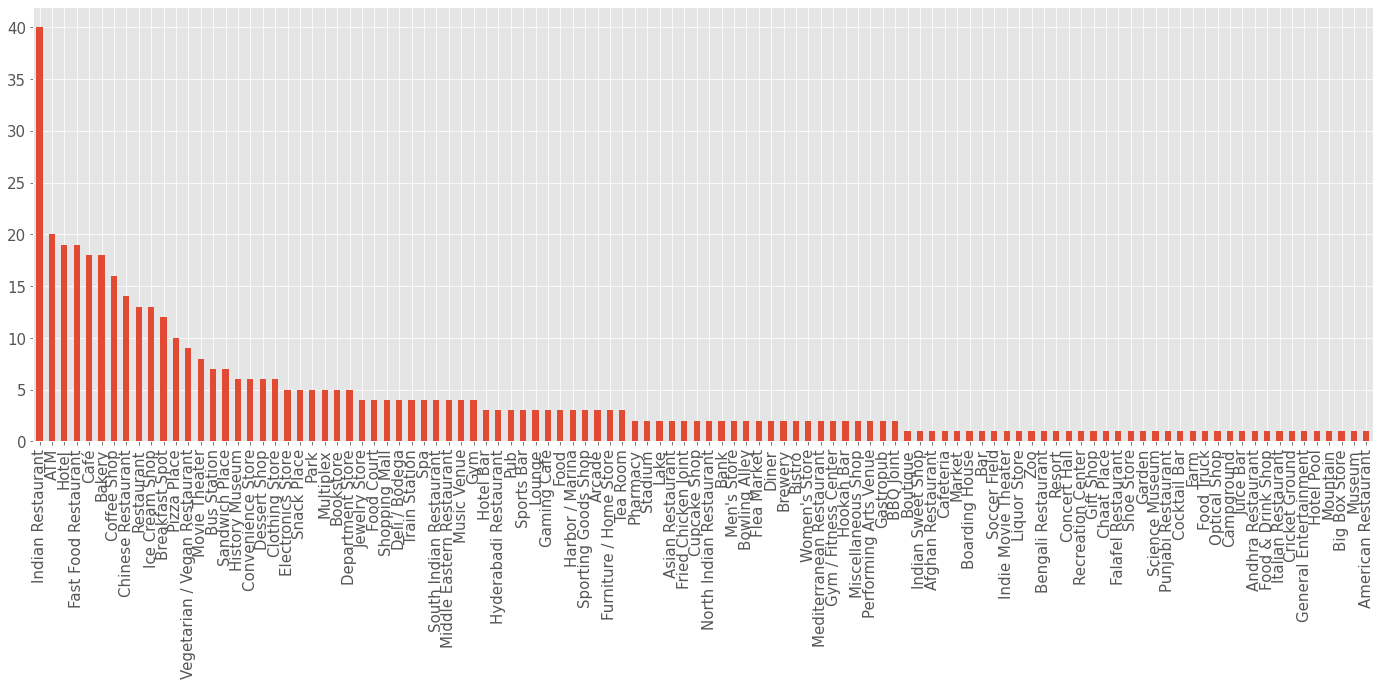

In [28]:
plt.figure(num=None, figsize=(24,8))
hyderabad_venues['Venue Category'].value_counts().plot(kind='bar',fontsize=15)

In [23]:
hyderabad_venues['Venue Category'].value_counts()

Indian Restaurant       40
ATM                     20
Hotel                   19
Fast Food Restaurant    19
Café                    18
                        ..
Hotel Pool               1
Mountain                 1
Big Box Store            1
Museum                   1
American Restaurant      1
Name: Venue Category, Length: 108, dtype: int64

There are 108 unique venue categories

### One Hot Encoding for each Pincode

In [30]:
# one hot encoding
hyderabad_onehot = pd.get_dummies(hyderabad_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighborhood column back to dataframe
hyderabad_onehot['Neighborhood'] = hyderabad_venues['Neighborhood'] 

# move neighborhood column to the first column
list_column = hyderabad_onehot.columns.tolist()
number_column = int(list_column.index('Neighborhood'))
list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:] 
hyderabad_onehot = hyderabad_onehot[list_column]

hyderabad_onehot.head()

,Neighborhood,ATM,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bank,...,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Tea Room,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Zoo
0,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Hyderabad Jubilee, Moghalpura, Tagarikanaka",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Next, let's group rows by Neighborhood and by taking the mean of the frequency of occurrence of each category

In [33]:
hyderabad_grouped = hyderabad_onehot.groupby('Neighborhood').mean().reset_index()
hyderabad_grouped

,Neighborhood,ATM,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Asian Restaurant,BBQ Joint,Bakery,Bank,...,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Tea Room,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Zoo
0,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,0.052632,...,0.052632,0.000000,0.000000,0.000000,0.00,0.000000,0.052632,0.052632,0.000000,0.000000
1,"A.Gs. staff quarters, Rahmath Nagar, Yousufguda",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Administrative Buildings, Iict, Jama I osmania...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Afzalgunj, Begumbazar, Osmania General hospital",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Aliabad, Anantaram, Atvelli, Dabirpur, Gajular...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Ambernagar, Andhra Mahila sabha, Nallakunta, N...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.125000,0.000000,0.000000,0.000000
6,"Amberpet, Central Police lines, Hyderabad Publ...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,Anantagiri,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Aphb Colony moulali, Ie Moulali, Moulali",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Ashoknagar, Golconda Chowrastha, Musheerabad D...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


Function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighborhood_venues_sorted = pd.DataFrame(columns=columns)
Neighborhood_venues_sorted['Neighborhood'] = hyderabad_grouped['Neighborhood']

for ind in np.arange(hyderabad_grouped.shape[0]):
    Neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hyderabad_grouped.iloc[ind, :], num_top_venues)

Neighborhood_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",Hotel,Hyderabadi Restaurant,Coffee Shop,Performing Arts Venue,Indian Restaurant,Ice Cream Shop,Café,Shoe Store,Bank,Bakery
1,"A.Gs. staff quarters, Rahmath Nagar, Yousufguda",Stadium,Bus Station,Dessert Shop,Breakfast Spot,Zoo,Farm,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega
2,"Administrative Buildings, Iict, Jama I osmania...",Indian Restaurant,Zoo,Fast Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop
3,"Afzalgunj, Begumbazar, Osmania General hospital",South Indian Restaurant,Food,Zoo,Farm,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
4,"Aliabad, Anantaram, Atvelli, Dabirpur, Gajular...",Gym / Fitness Center,Garden,Hotel,Dessert Shop,Lake,Farm,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega
5,"Ambernagar, Andhra Mahila sabha, Nallakunta, N...",Flea Market,Train Station,Café,Pharmacy,Food Court,Ice Cream Shop,Indian Restaurant,Electronics Store,Falafel Restaurant,Convenience Store
6,"Amberpet, Central Police lines, Hyderabad Publ...",General Entertainment,Convenience Store,Food & Drink Shop,Shopping Mall,Zoo,Farm,Concert Hall,Cricket Ground,Cupcake Shop,Deli / Bodega
7,Anantagiri,ATM,Bakery,Diner,Snack Place,Fast Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega
8,"Aphb Colony moulali, Ie Moulali, Moulali",Boarding House,Mountain,Zoo,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner
9,"Ashoknagar, Golconda Chowrastha, Musheerabad D...",Movie Theater,Convenience Store,Bakery,Zoo,Fast Food Restaurant,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop


### Clustering

In [121]:
len(hyderabad_grouped[hyderabad_grouped['Fast Food Restaurant']>0])

11

In [119]:
Restaurant_df=hyderabad_grouped[['Neighborhood','Fast Food Restaurant']]
Restaurant_df

,Neighborhood,Fast Food Restaurant
0,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",0.000000
1,"A.Gs. staff quarters, Rahmath Nagar, Yousufguda",0.000000
2,"Administrative Buildings, Iict, Jama I osmania...",0.000000
3,"Afzalgunj, Begumbazar, Osmania General hospital",0.000000
4,"Aliabad, Anantaram, Atvelli, Dabirpur, Gajular...",0.000000
5,"Ambernagar, Andhra Mahila sabha, Nallakunta, N...",0.000000
6,"Amberpet, Central Police lines, Hyderabad Publ...",0.000000
7,Anantagiri,0.000000
8,"Aphb Colony moulali, Ie Moulali, Moulali",0.000000
9,"Ashoknagar, Golconda Chowrastha, Musheerabad D...",0.000000


Using Elbow method to determine optimum value of K

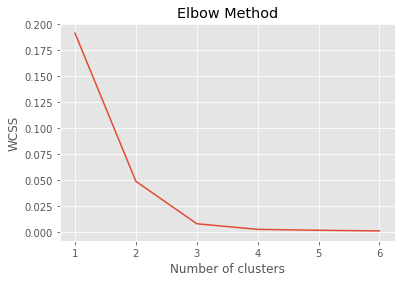

In [120]:
wcss = []
hyderabad_grouped_clustering = Restaurant_df.drop('Neighborhood', 1)
for i in range(1, 7):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=3)
    kmeans.fit(hyderabad_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [122]:
# set number of clusters
kclusters = 3

hyderabad_grouped_clustering = hyderabad_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(hyderabad_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 0])

In [125]:
Neighborhood_venues_sorted.insert(0, 'Cluster Labels', labels)
H_merged = df

# merge M_grouped with M_data to add latitude/longitude for each neighborhood
H_merged = H_merged.join(Neighborhood_venues_sorted.set_index('Neighborhood'), on='Location')

H_merged.head()# check the last columns!

,Pincode,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,500001,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147,1.0,Clothing Store,Chinese Restaurant,Stadium,Hotel Bar,Fast Food Restaurant,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
1,500002,"Hyderabad Jubilee, Moghalpura, Tagarikanaka",17.380252,78.466783,1.0,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Gaming Cafe,Park,South Indian Restaurant,Breakfast Spot,Zoo,Electronics Store,Concert Hall,Convenience Store
2,500003,"Begumpet Policelines, Kingsway, Mg Road, Picke...",17.441898,78.490840,1.0,Vegetarian / Vegan Restaurant,Arcade,Bakery,Indian Restaurant,Hotel,Fast Food Restaurant,Chinese Restaurant,Hyderabadi Restaurant,Department Store,Campground
3,500004,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",17.401951,78.463264,1.0,Hotel,Hyderabadi Restaurant,Coffee Shop,Performing Arts Venue,Indian Restaurant,Ice Cream Shop,Café,Shoe Store,Bank,Bakery
4,500005,"Balapur, Crp Camp, Keshogiri, Mamidipalli, Pah...",17.316797,78.484326,1.0,Middle Eastern Restaurant,Falafel Restaurant,Zoo,Farm,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store


In [126]:
H_merged.dropna(subset=["Cluster Labels"], axis =0 , inplace =True)

In [127]:
H_merged.astype({"Cluster Labels": "int32"}).head()

,Pincode,Location,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,500001,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",17.398710,78.472147,1,Clothing Store,Chinese Restaurant,Stadium,Hotel Bar,Fast Food Restaurant,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
1,500002,"Hyderabad Jubilee, Moghalpura, Tagarikanaka",17.380252,78.466783,1,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Gaming Cafe,Park,South Indian Restaurant,Breakfast Spot,Zoo,Electronics Store,Concert Hall,Convenience Store
2,500003,"Begumpet Policelines, Kingsway, Mg Road, Picke...",17.441898,78.490840,1,Vegetarian / Vegan Restaurant,Arcade,Bakery,Indian Restaurant,Hotel,Fast Food Restaurant,Chinese Restaurant,Hyderabadi Restaurant,Department Store,Campground
3,500004,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",17.401951,78.463264,1,Hotel,Hyderabadi Restaurant,Coffee Shop,Performing Arts Venue,Indian Restaurant,Ice Cream Shop,Café,Shoe Store,Bank,Bakery
4,500005,"Balapur, Crp Camp, Keshogiri, Mamidipalli, Pah...",17.316797,78.484326,1,Middle Eastern Restaurant,Falafel Restaurant,Zoo,Farm,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store


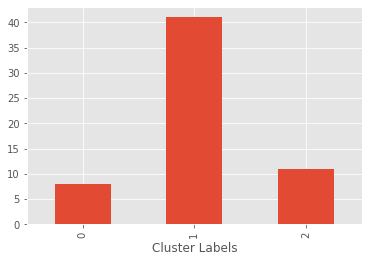

In [128]:
H_merged1 = H_merged.astype({"Cluster Labels": "int32"}).groupby(["Cluster Labels"]).count()
H_merged1["Pincode"].plot(kind = "bar")
plt.show()

### Visualizing Clusters

In [130]:
map_clusters = folium.Map(location=[17.360589, 78.4740613], zoom_start=10.75)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(H_merged['Latitude'], H_merged['Longitude'], H_merged['Location'], H_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

### Examine Clusters

In [131]:
H_merged.loc[H_merged['Cluster Labels'] == 0, H_merged.columns[[1] + list(range(5, H_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Raj Bhawan,ATM,Music Venue,Afghan Restaurant,American Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
36,Hindustan Cables ltd,ATM,Music Venue,Afghan Restaurant,American Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
38,"Falaknuma, Uppuguda",ATM,Music Venue,Afghan Restaurant,American Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
41,"Saidabad, Saidabad Colony, Santoshnagar Colony",ATM,Indian Restaurant,Breakfast Spot,Coffee Shop,Farm,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
47,"Fatehdarwaza, Quazipura, Shahalibanda, Sultans...",ATM,Bakery,Flea Market,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner
50,"Gsi(sr) Bandlaguda, Mansoorabad",ATM,Ice Cream Shop,Fast Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop
58,"Jillellaguda, Karmanghat, Vaishalinagar",ATM,Farm,Jewelry Store,Gastropub,Garden,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega
64,Vikarabad,ATM,Music Venue,Afghan Restaurant,American Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store


In [132]:
H_merged.loc[H_merged['Cluster Labels'] == 1, H_merged.columns[[1] + list(range(5, H_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Gandhi Bhawan, Hindi Bhawan, Hyderabad., Moazz...",Clothing Store,Chinese Restaurant,Stadium,Hotel Bar,Fast Food Restaurant,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
1,"Hyderabad Jubilee, Moghalpura, Tagarikanaka",Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,Gaming Cafe,Park,South Indian Restaurant,Breakfast Spot,Zoo,Electronics Store,Concert Hall,Convenience Store
2,"Begumpet Policelines, Kingsway, Mg Road, Picke...",Vegetarian / Vegan Restaurant,Arcade,Bakery,Indian Restaurant,Hotel,Fast Food Restaurant,Chinese Restaurant,Hyderabadi Restaurant,Department Store,Campground
3,"A.Gs office, Anandnagar, Bazarghat, Khairataba...",Hotel,Hyderabadi Restaurant,Coffee Shop,Performing Arts Venue,Indian Restaurant,Ice Cream Shop,Café,Shoe Store,Bank,Bakery
4,"Balapur, Crp Camp, Keshogiri, Mamidipalli, Pah...",Middle Eastern Restaurant,Falafel Restaurant,Zoo,Farm,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
5,"Dhoolpet, Karwan Sahu, Mangalhat",Zoo,Café,Bakery,Fast Food Restaurant,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop
7,"Dargah Hussain shahwali, Golconda, Hyder Shah ...",Cricket Ground,Zoo,Fast Food Restaurant,Concert Hall,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner
8,"Afzalgunj, Begumbazar, Osmania General hospital",South Indian Restaurant,Food,Zoo,Farm,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
9,"Amberpet, Central Police lines, Hyderabad Publ...",General Entertainment,Convenience Store,Food & Drink Shop,Shopping Mall,Zoo,Farm,Concert Hall,Cricket Ground,Cupcake Shop,Deli / Bodega
10,"Aliabad, Anantaram, Atvelli, Dabirpur, Gajular...",Gym / Fitness Center,Garden,Hotel,Dessert Shop,Lake,Farm,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega


In [133]:
H_merged.loc[H_merged['Cluster Labels'] == 2, H_merged.columns[[1] + list(range(5, H_merged.shape[1]))]]

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Administrative Buildings, Iict, Jama I osmania...",Indian Restaurant,Zoo,Fast Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop
15,Central Secretariat,Indian Restaurant,Science Museum,Park,Hotel,Farm,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega
17,"Chanchalguda, Darushifa, Sahifa",Indian Restaurant,Train Station,Convenience Store,Hotel,Zoo,Farm,Concert Hall,Cricket Ground,Cupcake Shop,Deli / Bodega
18,"Himmatnagar, Padmaraonagar",Park,Bakery,Vegetarian / Vegan Restaurant,Train Station,Indian Restaurant,Electronics Store,Diner,Dessert Shop,Department Store,Zoo
21,"Dattatreya Colony, Humayunnagar, Murad Nagar, ...",Indian Restaurant,Chinese Restaurant,Spa,Zoo,Fast Food Restaurant,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
24,Ibrahim Bagh lines,Indian Restaurant,Snack Place,Zoo,Fast Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store
27,"Huda Residential complex, Ramakrishanapuram, S...",Movie Theater,Indian Restaurant,Bowling Alley,Restaurant,Falafel Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Deli / Bodega
29,"Sanjeev Reddy nagar, Vengal Rao nagar",Indian Restaurant,Breakfast Spot,Clothing Store,Café,Sporting Goods Shop,Department Store,Pizza Place,Zoo,Falafel Restaurant,Convenience Store
53,Rail Nilayam,Fast Food Restaurant,Indian Restaurant,Bakery,Cafeteria,Ice Cream Shop,Shopping Mall,Multiplex,Convenience Store,Cricket Ground,Cupcake Shop
60,"Cyberabad, Madhapur",Indian Restaurant,Restaurant,Fast Food Restaurant,Food Truck,Lounge,Chinese Restaurant,Mediterranean Restaurant,Italian Restaurant,Café,Multiplex
